# Visualize some basic behavioural stuff on the sample dataset

In [5]:
datafolder = 'Data/steinmetz_sampledata' #point to folder where you've saved the sample 'steinmetz....npz' files

In [6]:
cd

/Users/sam


In [7]:
## Data loading (this takes a while so only run this once)
import numpy as np
import os, requests

alldat = np.array([])
for j in range(3):
    alldat = np.hstack((alldat, np.load(os.path.join(datafolder,'steinmetz_part%d.npz'%j), allow_pickle=True)['dat']))

print(alldat.shape)

(39,)


In [8]:
# select just one of the 39 recordings here. 
# according to Steinmetz, 11 is nice because it has some neurons in vis ctx. 
dat = alldat[21]
print(dat.keys())

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])


`alldat` contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each `dat = alldat[k]`, you have the following fields:

* `dat['mouse_name']`: mouse name
* `dat['date_exp']`: when a session was performed
* `dat['spks']`: neurons by trials by time bins.    
* `dat['brain_area']`: brain area for each neuron recorded. 
* `dat['contrast_right']`: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
* `dat['contrast_left']`: contrast level for left stimulus. 
* `dat['gocue']`: when the go cue sound was played. 
* `dat['response_times']`: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.  
* `dat['response']`: which side the response was (`-1`, `0`, `1`). When the right-side stimulus had higher contrast, the correct choice was `-1`. `0` is a no go response. 
* `dat['feedback_time']`: when feedback was provided. 
* `dat['feedback_type']`: if the feedback was positive (`+1`, reward) or negative (`-1`, white noise burst).  
* `dat['wheel']`: exact position of the wheel that the mice uses to make a response, binned at `10ms`. 
* `dat['pupil']`: pupil area  (noisy, because pupil is very small) + pupil horizontal and vertical position. 
* `dat['lfp']`: recording of the local field potential in each brain area from this experiment, binned at `10ms`.
* `dat['brain_area_lfp']`: brain area names for the LFP channels. 
* `dat['trough_to_peak']`: measures the width of the action potential waveform for each neuron. Widths `<=10` samples are "putative fast spiking neurons". 
* `dat['waveform_w']`: temporal components of spike waveforms. `w@u` reconstructs the time by channels action potential shape. 
* `dat['waveform_u]`: spatial components of spike waveforms.
* `dat['%X%_passive']`: same as above for `X` = {`spks`, `lfp`, `pupil`, `wheel`, `contrast_left`, `contrast_right`} but for  passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses. 

In [9]:
## import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

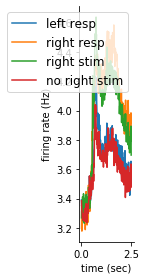

In [10]:
## basic plots of population average
from matplotlib import pyplot as plt
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]

#ax = plt.subplot(1,5,1)
ax = plt.subplot(1,5,1)
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response>=0].mean(axis=(0,1))) # left responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,response<0].mean(axis=(0,1))) # right responses
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right>0].mean(axis=(0,1))) # stimulus on the right
plt.plot(dt * np.arange(NT), 1/dt * dat['spks'][:,vis_right==0].mean(axis=(0,1))) # no stimulus on the right

plt.legend(['left resp', 'right resp', 'right stim', 'no right stim'], fontsize=12)
ax.set(xlabel  = 'time (sec)', ylabel = 'firing rate (Hz)');

In [11]:
#sort correct vs incorrect trials

# the following are the correct responses:
# if vis_left > vis_right : response >0
# if vis_left < vis_right : response <0
# if vis_left = vis_right : response =0
# trials below red line are incorrect
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

nwrong = np.sum(is_correct)

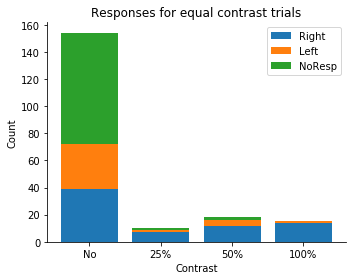

In [12]:
#in this cell we select all the trials in which the contrast was equal on both sides
#for contrast 0, the animal was rewarded for not responding. 
#For non-zero contrast, the animal was rewarded randomly for either left or right response
#we sort the contrasts into 4 possibilities: 0, .25, .5 or 1
#we sort the responses into three possibilities: right, left, or nogo
#we then plot the number of trials for this animal

response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high

contrasts = [0,.25,.5,1]
nogo_allresp = np.zeros((len(contrasts),3))

for i,contrast_type in enumerate(contrasts):
    nogo_type = (vis_left==contrast_type)*(vis_right==contrast_type)
    nogo_allresp[i,:] = np.array([np.sum(nogo_type*(response==1)),np.sum(nogo_type*(response==-1)),np.sum(nogo_type*(response==0))])

nogo_no = (vis_left==0)*(vis_right==0)

plt.figure(figsize=[5,4])

p1 = plt.bar(range(4), nogo_allresp[:,0])
p2 = plt.bar(range(4), nogo_allresp[:,1],bottom=nogo_allresp[:,0])
p3 = plt.bar(range(4), nogo_allresp[:,2],bottom=nogo_allresp[:,1]+nogo_allresp[:,0])

plt.ylabel('Count')
plt.xlabel('Contrast')
plt.title('Responses for equal contrast trials')
plt.xticks(range(4), ('No','25%','50%','100%'))
#plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0], p3[0]), ('Right', 'Left', 'NoResp'))

plt.show()

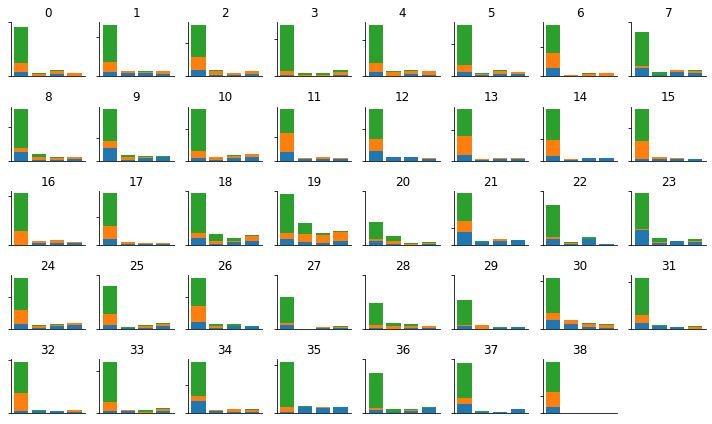

In [13]:
#in this cell we do the same as above but looping over all sample datasets

plt.figure(figsize=[10,6])

for isess,datx in enumerate(alldat):
    
    responsex = datx['response'] # right - nogo - left (-1, 0, 1)
    vis_rightx = datx['contrast_right'] # 0 - low - high
    vis_leftx = datx['contrast_left'] # 0 - low - high

    contrastsx = [0,.25,.5,1]
    nogo_allrespx = np.zeros((len(contrasts),3))
    
    for i,contrast_type in enumerate(contrasts):
        nogo_typex = (vis_leftx==contrast_type)*(vis_rightx==contrast_type)
        nogo_allrespx[i,:] = np.array([np.sum(nogo_typex*(responsex==1)),np.sum(nogo_typex*(responsex==-1)),np.sum(nogo_typex*(responsex==0))])
    
    plt.subplot(5,8,isess+1)
    
    p1 = plt.bar(range(4), nogo_allrespx[:,0])
    p2 = plt.bar(range(4), nogo_allrespx[:,1],bottom=nogo_allrespx[:,0])
    p3 = plt.bar(range(4), nogo_allrespx[:,2],bottom=nogo_allrespx[:,1]+nogo_allrespx[:,0])
    
    ax = plt.gca()
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([0,50])
    ax.axes.set_yticklabels([])
    
    plt.title('%d'%isess)
    
plt.show()

In [19]:
binsize = 0.01 #in seconds

wheelpos_raw = dat['wheel'][0]
cue_time = dat['gocue']
resp_time = dat['response_time']

resp_time_idx = np.round(resp_time/binsize)
resp_time_idx.astype(int)

cue_time_idx = np.round((cue_time/binsize))
cue_time_idx.astype(int)

wheelpos_raw_postcue = np.full_like(wheelpos_raw,np.nan)
for i in range(wheelpos_raw.shape[0]):
    wheelpos_raw_postcue[i,int(cue_time_idx[i]):] = wheelpos_raw[i,int(cue_time_idx[i]):]

t_raw = np.arange(0,wheelpos_raw.shape[1]*binsize-binsize,binsize)

binsize = 0.01 #in seconds

t_cuewin = [-.48,1.2] #in seconds
t_cue = np.arange(t_cuewin[0],t_cuewin[1],binsize)
wheelpos_cue = np.zeros((len(cue_time),int(np.diff(np.array(t_cuewin)/binsize))))
wheelpos_cue_postcue = np.zeros((len(cue_time),int(np.diff(np.array(t_cuewin)/binsize))))

for i,val in enumerate(cue_time_idx):
    wheelpos_cue[i,:] = wheelpos_raw[i,int(val+t_cuewin[0]/binsize):int(val+t_cuewin[1]/binsize)]
    wheelpos_cue_postcue[i,:] = wheelpos_raw_postcue[i,int(val+t_cuewin[0]/binsize):int(val+t_cuewin[1]/binsize)]

# t_respwin = [-.3,1] #in seconds
# t_resp = np.arange(t_respwin[0],t_respwin[1],binsize)
# wheelpos_resp = np.zeros((len(resp_time),int(np.diff(np.array(t_respwin)/binsize))))
# wheelpos_resp_postresp = np.zeros((len(resp_time),int(np.diff(np.array(t_respwin)/binsize))))

# for i,val in enumerate(resp_time_idx):
#     wheelpos_resp[i,:] = wheelpos_raw[i,int(val+t_respwin[0]/binsize):int(val+t_respwin[1]/binsize)]
#     wheelpos_resp_postresp[i,:] = wheelpos_raw_postcue[i,int(val+t_respwin[0]/binsize):int(val+t_respwin[1]/binsize)]

In [20]:
print(wheelpos_raw.shape)
print(wheelpos_cue.shape)
print(t_raw.shape)
print(t_cue.shape)

(444, 250)
(444, 168)
(250,)
(168,)


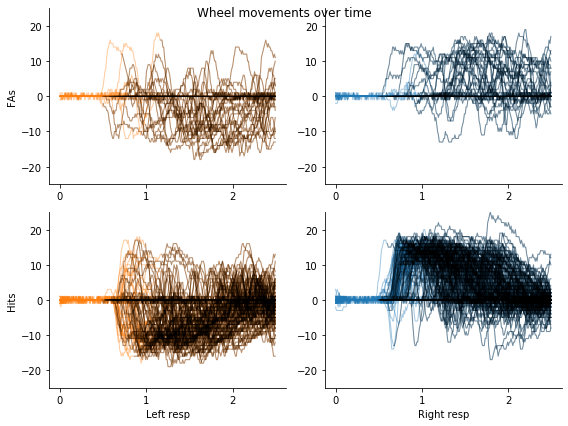

In [36]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
trls_NR = nogo_no*(response==1)
trls_NL = nogo_no*(response==-1)
trls_GR = ~nogo_no*(response==1)
trls_GL = ~nogo_no*(response==-1)

#wheelpos_raw = dat['wheel'][0]

plt.figure(figsize=[8,6])

plt.subplot(221)
plt.plot(wheelpos_raw[np.where(trls_NL)].T,cols[1],alpha=.4,linewidth=1)
plt.plot(wheelpos_raw_postcue[np.where(trls_NL)].T,'k',alpha=.3,linewidth=1)
plt.ylim(-25,25)
plt.xticks([0,100,200],[0,1,2])
plt.ylabel('FAs')
#plt.scatter(resp_time[np.where(trls_NL)],20*np.ones_like(resp_time[np.where(trls_NL)]),10,'k')

plt.subplot(222)
plt.plot(wheelpos_raw[np.where(trls_NR)].T,cols[0],alpha=.4,linewidth=1)
plt.plot(wheelpos_raw_postcue[np.where(trls_NR)].T,'k',alpha=.3,linewidth=1)
plt.xticks([0,100,200],[0,1,2])
plt.ylim(-25,25)

plt.subplot(223)
plt.plot(wheelpos_raw[np.where(trls_GL)].T,cols[1],alpha=.4,linewidth=1)
plt.plot(wheelpos_raw_postcue[np.where(trls_GL)].T,'k',alpha=.3,linewidth=1)
plt.ylim(-25,25)
plt.xticks([0,100,200],[0,1,2])
plt.xlabel('Left resp')
plt.ylabel('Hits')

plt.subplot(224)
plt.plot(wheelpos_raw[np.where(trls_GR)].T,cols[0],alpha=.4,linewidth=1)
plt.plot(wheelpos_raw_postcue[np.where(trls_GR)].T,'k',alpha=.3,linewidth=1)
plt.ylim(-25,25)
plt.xticks([0,100,200],[0,1,2])
plt.xlabel('Right resp')

plt.tight_layout()

plt.suptitle("Wheel movements over time")

code_folder = os.path.join('/Users/sam/Code/NMA','NMA_project')
plt.savefig(os.path.join(code_folder,'figs','wheel_movements_example.svg'))
plt.savefig(os.path.join(code_folder,'figs','wheel_movements_example.png'),dpi=300)

plt.show()

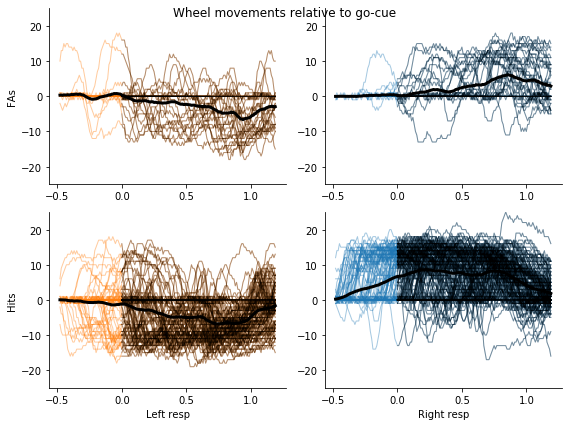

In [37]:
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
trls_NR = nogo_no*(response==1)
trls_NL = nogo_no*(response==-1)
trls_GR = ~nogo_no*(response==1)
trls_GL = ~nogo_no*(response==-1)

wheelpos = wheelpos_cue
wheelpos_postcue = wheelpos_cue_postcue
t = t_cue

plt.figure(figsize=[8,6])

plt.subplot(221)
plt.plot(t,wheelpos[np.where(trls_NL)].T,cols[1],alpha=.4,linewidth=1)
plt.plot(t,wheelpos_postcue[np.where(trls_NL)].T,'k',alpha=.3,linewidth=1)
plt.plot(t,np.mean(wheelpos[np.where(trls_NL)],axis=0),'k',linewidth=3)
plt.ylim(-25,25)
plt.xticks([-.5,0,.5,1])
plt.ylabel('FAs')

plt.subplot(222)
plt.plot(t,wheelpos[np.where(trls_NR)].T,cols[0],alpha=.4,linewidth=1)
plt.plot(t,wheelpos_postcue[np.where(trls_NR)].T,'k',alpha=.3,linewidth=1)
plt.plot(t,np.mean(wheelpos[np.where(trls_NR)],axis=0),'k',linewidth=3)
plt.ylim(-25,25)
plt.xticks([-.5,0,.5,1])

plt.subplot(223)
plt.plot(t,wheelpos[np.where(trls_GL)].T,cols[1],alpha=.4,linewidth=1)
plt.plot(t,wheelpos_postcue[np.where(trls_GL)].T,'k',alpha=.3,linewidth=1)
plt.plot(t,np.mean(wheelpos[np.where(trls_GL)],axis=0),'k',linewidth=3)
plt.ylim(-25,25)
plt.xticks([-.5,0,.5,1])
plt.xlabel('Left resp')
plt.ylabel('Hits')

plt.subplot(224)
plt.plot(t,wheelpos[np.where(trls_GR)].T,cols[0],alpha=.4,linewidth=1)
plt.plot(t,wheelpos_postcue[np.where(trls_GR)].T,'k',alpha=.3,linewidth=1)
plt.plot(t,np.mean(wheelpos[np.where(trls_GR)],axis=0),'k',linewidth=3)
plt.ylim(-25,25)
plt.xticks([-.5,0,.5,1])
plt.xlabel('Right resp')

plt.tight_layout()

plt.suptitle("Wheel movements relative to go-cue")

plt.savefig(os.path.join(code_folder,'figs','wheel_mov_aligned_example.svg'))
plt.savefig(os.path.join(code_folder,'figs','wheel_mov_aligned_example.png'),dpi=300)

plt.show()
#conclusion: animals don't wait until the go-cue to respond!


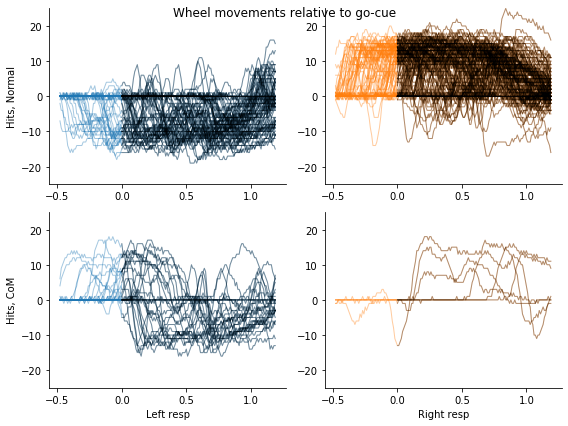

In [38]:
#'Change of Mind' (com) trials are those where the mean direction of initial movement was in wrong direction
# we define this over the window 'init_win', relative to the go cue

com_win = np.array([-0.2,0.1])
win = np.round((com_win - t_cuewin[0])/binsize)
win.astype(int)

#com_win = np.array([0.6,0.8])
#win = np.round(com_win/binsize)
#win.astype(int)

wheelpos = wheelpos_cue
wheelpos_postcue = wheelpos_cue_postcue
t = t_cue

trls_GR_com = ~nogo_no*(response==1)*(np.mean(wheelpos[:,int(win[0]):int(win[1])],axis=1)<0)
trls_GL_com = ~nogo_no*(response==-1)*(np.mean(wheelpos[:,int(win[0]):int(win[1])],axis=1)>0)

trls_GR_ok = ~nogo_no*(response==1)*(np.mean(wheelpos[:,int(win[0]):int(win[1])],axis=1)>=0)
trls_GL_ok = ~nogo_no*(response==-1)*(np.mean(wheelpos[:,int(win[0]):int(win[1])],axis=1)<=0)

plt.figure(figsize=[8,6])

plt.subplot(221)
plt.plot(t,wheelpos[np.where(trls_GL_ok)].T,cols[0],alpha=.4,linewidth=1)
plt.plot(t,wheelpos_postcue[np.where(trls_GL_ok)].T,'k',alpha=.3,linewidth=1)
plt.ylim(-25,25)
plt.ylabel('Hits, Normal')

plt.subplot(222)
plt.plot(t,wheelpos[np.where(trls_GR_ok)].T,cols[1],alpha=.4,linewidth=1)
plt.plot(t,wheelpos_postcue[np.where(trls_GR_ok)].T,'k',alpha=.3,linewidth=1)
plt.ylim(-25,25)

plt.subplot(223)
plt.plot(t,wheelpos[np.where(trls_GL_com)].T,cols[0],alpha=.4,linewidth=1)
plt.plot(t,wheelpos_postcue[np.where(trls_GL_com)].T,'k',alpha=.3,linewidth=1)
plt.ylim(-25,25)
plt.xlabel('Left resp')
plt.ylabel('Hits, CoM')

plt.subplot(224)
plt.plot(t,wheelpos[np.where(trls_GR_com)].T,cols[1],alpha=.4,linewidth=1)
plt.plot(t,wheelpos_postcue[np.where(trls_GR_com)].T,'k',alpha=.3,linewidth=1)
plt.ylim(-25,25)
plt.xlabel('Right resp')

plt.tight_layout()

plt.suptitle("Wheel movements relative to go-cue")

plt.savefig("/Users/sam/Code/NMA/NMA_project/figs/wheel_mov_changesofmind.svg")
plt.savefig("/Users/sam/Code/NMA/NMA_project/figs/wheel_mov_changesofmind",dpi=300)

plt.show()